In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import warnings
import time
%matplotlib inline

In [9]:
%load_ext autoreload
%autoreload 2
import c14
import c14.models.minimal
import c14.models.amygdala

models_listd = {m.__name__:m for m in c14.models.amygdala.models_list}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
datao = pd.read_csv('data/C14 samples Erlangen 2019_20190830.csv')
datao = datao.groupby(['ID', 'tissue', 'labelling']).mean().dropna(how='all').reset_index()
datao['age'] = datao['Dcoll'] - datao['Dbirth']
datao['e14C'] = datao['error_measurement']
datao = datao.query('tissue == "Amygdala" and labelling == "NeuN+"')
data = datao.append(pd.Series({'ID':'P5new','tissue':'Amygdala','labelling':'NeuN+',
             'Dbirth':1973,'Dcoll':2017,'subject_age':44,'age':44,
            'd14C':(datao.loc[16,'d14C'] + datao.loc[14,'d14C'])/2,
            'e14C':(datao.loc[16,'e14C'] + datao.loc[14,'e14C'])/2,
            'error_measurement':(datao.loc[16,'e14C'] + datao.loc[14,'e14C'])/2},name=22)).drop([14,16])
data

,ID,tissue,labelling,Dbirth,Dcoll,d14C,error_measurement,subject_age,age,e14C
0,ER2019_01,Amygdala,NeuN+,1932,2012,0.00540,0.009000,80,80,0.009000
4,ER2019_02,Amygdala,NeuN+,1936,2012,-0.00130,0.010000,76,76,0.010000
8,ER2019_03,Amygdala,NeuN+,1954,2017,-0.00330,0.006350,63,63,0.006350
12,ER2019_04,Amygdala,NeuN+,1969,2017,0.45630,0.010900,48,48,0.010900
22,P5new,Amygdala,NeuN+,1973,2017,0.32205,0.007725,44,44,0.007725


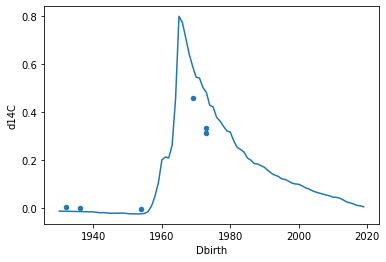

In [11]:
datao.plot(x='Dbirth',y='d14C',kind='scatter')
T=np.arange(1930,2020,1)
plt.plot(T,c14.Catm().lin(T))

In [12]:
#fitting the models takes a lot of time

for mn in ['x2POP','A','LinB']:
    model = models_listd[mn]()
    m = model
    op = c14.optimize(model=model,data=c14.exp_data(data),step_size=0.1)
    error = {pname:0.1 for pname in model.parameter_names}   
    res = op.optimize_emcee(nwalkers=model.nparas*50,processes=16,steps=3000,seed=43,
                                mode="uniform_test",error=error,
                                fake_gradient=False,m_max=2000)   
    
    with pd.HDFStore('sim_results_p5mean_2.pandas') as st:
        st[mn] = pd.Series([None,res[1],res[2],res[3]])


'\nfor mn in [\'x2POP\',\'A\',\'LinB\']:\n    model = models_listd[mn]()\n    m = model\n    op = c14.optimize(model=model,data=c14.exp_data(data),step_size=0.1)\n    error = {pname:0.1 for pname in model.parameter_names}   \n    res = op.optimize_emcee(nwalkers=model.nparas*50,processes=16,steps=3,seed=43,\n                                mode="uniform_test",error=error,\n                                fake_gradient=False,m_max=2000)   \n    \n    with pd.HDFStore(\'sim_results_fix_6.pandas\') as st:\n        st[mn] = pd.Series([None,res[1],res[2],res[3]])\n'

In [13]:
from c14.utils import *

In [14]:
np.seterr(all='ignore')
results= dict()
NUM=0
results= dict(data=data,results={},models={})
resultsB= dict(data=data,results={},models={})

for mn in   ['x2POP','A','LinB']:
    m = models_listd[mn]()
    with pd.HDFStore('sim_results_p5mean_2.pandas') as st:

        res = st[m.__class__.__name__]

        
    results['results'].update(  {m.__class__.__name__ : {'raw':res} } )
    results['models'].update(   {m.__class__.__name__ : m } )


get_arviz(results)    


Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default parameters missing sigma added automatikcally with limits 0,0.2


x2POP
0  chains are stuck
WARN: The number of effective samples is smaller than 10% for some parameters.


A
0  chains are stuck
WARN: The number of effective samples is smaller than 10% for some parameters.


LinB
0  chains are stuck
INFO: The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
WARN: The number of effective samples is smaller than 10% for some parameters.




In [17]:
printt = get_pointestimates(results,error_in_real=False,sigma=1)
a=printt[['Parameter','Value','Confidence Interval']]
a.to_excel('results_sigma.xlsx')
a

Parameter         Value  \
rank Scenario loo  Weight dummy                           
0    x2POP    7.5  84%    0          beta   17.00%/year   
                          0             f        0.2927   
                          0         sigma        0.0316   
1    LinB     4.97 10%    0         beta0    11.3%/year   
                          0        beta10  0.0373%/year   
                          0         sigma        0.0766   
2    A        4.62 5%     0          beta   0.234%/year   
                          0         sigma        0.0904   

                                             Confidence Interval  
rank Scenario loo  Weight dummy                                   
0    x2POP    7.5  84%    0        [10.748%/year - 49.997%/year]  
                          0                  [0.23354 - 0.34324]  
                          0                  [0.01322 - 0.04455]  
1    LinB     4.97 10%    0           [0.28%/year - 50.00%/year]  
                          0      [0.00133%/year - 0.85869%/year]  
                          0                  [0.03967 - 0.10101]  
2    A        4.62 5%     0        [0.0245%/year - 1.3528%/year]  
                          0                  [0.04879 - 0.11591]

In [18]:
para_rename={'beta':r"beta",'beta0':r"beta0",'beta10':r"beta10",'sigma':r"sigma",'f':r"f",'s':r"$s$",'beta_mean':r'$\gamma_{m}$','beta_width':r'$\gamma_{w}$'}
import seaborn as sns
from matplotlib import rcParams,rc
import c14.corner
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl

<ipython-input-19-0d6a555d6941>:12: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[
<ipython-input-19-0d6a555d6941>:38: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('red')
R[write to console]: Loading required package: ks

R[write to console]: Loading required package: gplots

R[write to console]: 
Attaching package: ‘gplots’


R[write to console]: The following object is masked from ‘package:stats’:

    lowess




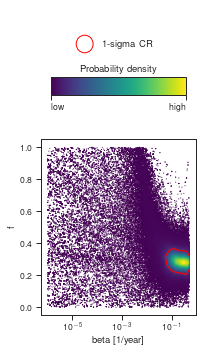

In [19]:
import seaborn as sns
from matplotlib import rcParams,rc
import c14.corner
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl

fonts = 1
sns.set(context="paper",style='ticks',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)

n='x2POP'
v=results['results'][n]  
chain=v['azdata'].posterior.a.values
parameter_names=results['models'][n].parameter_names
burnin=0
rename=para_rename
logparas=results['models'][n].logparas
unitlog=r"[1/year]"
rasterized=True

leng = chain.shape[2]
chainf = chain[:,burnin:,:].reshape(-1,leng)

fig, axes = plt.subplots(2, 1, figsize=(3,6 ))
cmap = plt.cm.viridis
cmap.set_under('red')
if parameter_names is None:
    parameter_names = [i for i in range(leng)]

ix,namex = [[a,b] for a,b in enumerate(parameter_names)][0]
iy,namey = [[a,b] for a,b in enumerate(parameter_names)][1]

ax= axes[1]
z = c14.corner.r_kde(chainf[:,[ix,iy]])
idx = z.argsort()
sort_chain = chainf[:,[ix,iy]][idx]
ax.scatter(sort_chain[:,0],sort_chain[:,1], c=z[idx],cmap=cmap , s=0.1, edgecolor=None,rasterized=rasterized)
for i in c14.corner.ci2d(chainf[:,[ix,iy]]):
    ax.plot(i.x,i.y,color='red')
if rename is not None:
    ax.set_ylabel( rename[namey])
else:
    ax.set_ylabel(namey)
if rename is not None:
    ax.set_xlabel( rename[namex])
else:
    ax.set_xlabel(namex)
if namey in logparas:
    ax.yaxis.set_major_locator(plt.FixedLocator([-5,-3,-1]))
    ticks = ax.get_yticks()
    ax.set_yticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
    label = ax.get_ylabel()
    ax.set_ylabel(label+" "+unitlog)
if namex in logparas:
    ax.xaxis.set_major_locator(plt.FixedLocator([-5,-3,-1]))
    ticks = ax.get_xticks()
    ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
    label = ax.get_xlabel()
    ax.set_xlabel(label+" "+unitlog)

plt.tight_layout()
plt.draw()
    
bbax0 = fig.get_axes()[0].get_position()
bbax3 = fig.get_axes()[1].get_position()
axL=plt.axes([bbax3.x0+0.1, bbax0.y0+bbax0.height*0.1,  bbax3.width-.2, bbax0.height*.5], frameon=False, xticks=[],yticks=[])
axL.set_xlim((0,1))
axL.set_ylim((0,1))
ellipse = patches.Ellipse(xy=(0.2,0.58), height=0.2, width=0.15, angle=0 ,      edgecolor='red', fc='None', lw=1)
axL.text(0.35, 0.55, "1-sigma CR")
axL.add_patch(ellipse)
axC=plt.axes([bbax3.x0+0.05, bbax0.y0+bbax0.height*0.1,bbax3.width-0.1,bbax0.height*0.1], frameon=True)
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,cax=axC,orientation='horizontal')
cbar.set_ticks([0,1])
cbar.set_ticklabels(['low','high'])
axC.set_title('Probability density')
axC.xaxis.get_major_ticks()[0].label1.set_horizontalalignment('left')
axC.xaxis.get_major_ticks()[1].label1.set_horizontalalignment('right')
a =axes[0]
a.remove() 


plt.savefig('C.pdf',dpi=600)

<ipython-input-20-b4a76dcd0275>:17: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[
/home/julian/uni/c14/c14/c14/corner.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])


x2POP


/home/julian/uni/c14/c14/c14/corner.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])


A


/home/julian/uni/c14/c14/c14/corner.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
/home/julian/uni/c14/c14/c14/corner.py:123: UserWarning: FixedFormatter 

LinB


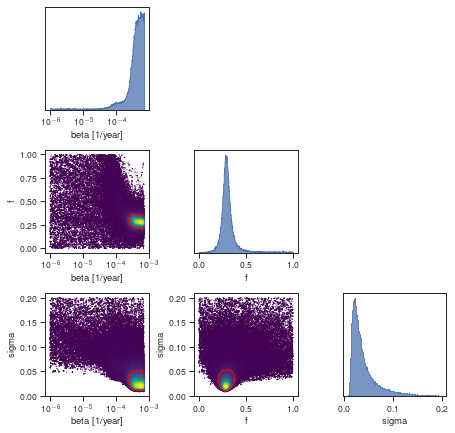

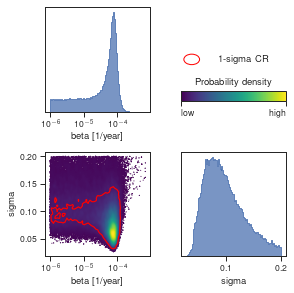

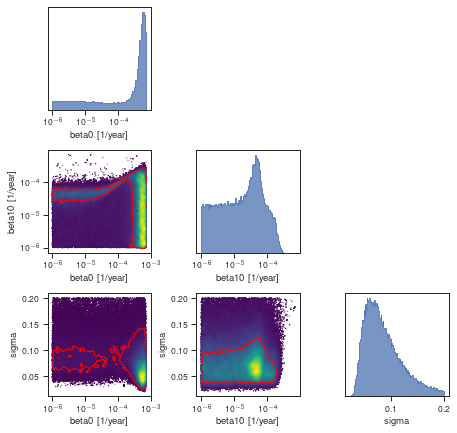

In [20]:
mrename = {'SB':'S',
'S2B':'S2POP',
'LinB':'LIN',
'x2POP':'POP1q',
'N':'N','A':'POP1'}
import jr
import c14.corner
from matplotlib import rcParams,rc
import seaborn as sb
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl
fonts = 1
sns.set(context="paper",style='ticks',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)
#para_rename={'beta':r"$\gamma$",'beta0':r"$\gamma_0$",'beta10':r"$\gamma_{10}$",'sigma':r"$\sigma$",'f':r"$f$",'s':r"$s$",'beta_mean':r'$\gamma_{m}$','beta_width':r'$\gamma_{w}$'}

for n,vv in results['models'].items():  
    m = vv
    v= results['results'][n]
    a = c14.corner.corner_R(v['azdata'].posterior.a.values,
                    m.parameter_names,rename=para_rename,
                     logparas=m.logparas,unitlog=r"[1/year]",point_estimate=None,rasterized=True,mindim=10)
    f = plt.gcf()
    plt.draw()
    print(n)
    if n=='A':
        bbax0 = f.get_axes()[0].get_position()
        bbax3 = f.get_axes()[2].get_position()

        axL=plt.axes([bbax3.x0, bbax0.y0+bbax0.height*0.1,  bbax3.width, bbax0.height*.5], frameon=False, xticks=[],yticks=[])
        axL.set_xlim((0,1))
        axL.set_ylim((0,1))
        ellipse = patches.Ellipse(xy=(0.1,0.8), height=0.2, width=0.15, angle=0 ,      edgecolor='red', fc='None', lw=1)
        axL.text(0.35, 0.75, "1-sigma CR")
        axL.add_patch(ellipse)
        axC=plt.axes([bbax3.x0, bbax0.y0+bbax0.height*0.1,bbax3.width,bbax0.height*0.1], frameon=True)
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm,cax=axC,orientation='horizontal')
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['low','high'])
        axC.set_title('Probability density')
        axC.xaxis.get_major_ticks()[0].label1.set_horizontalalignment('left')
        axC.xaxis.get_major_ticks()[1].label1.set_horizontalalignment('right')

    plt.draw()
    
    plt.savefig('neu+'+ mrename[n]+'.pdf',dpi=600)


In [21]:
mrename = {'SB':'S',
'S2B':'S2POP',
'LinB':'LIN',
'x2POP':'POP1q',
'N':'N','A':'POP1'}
import jr
import c14.corner
from matplotlib import rcParams,rc
import seaborn as sb
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl
fonts = 1
sns.set(context="paper",style='ticks',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)
#para_rename={'beta':r"$\gamma$",'beta0':r"$\gamma_0$",'beta10':r"$\gamma_{10}$",'sigma':r"$\sigma$",'f':r"$f$",'s':r"$s$",'beta_mean':r'$\gamma_{m}$','beta_width':r'$\gamma_{w}$'}

for n,vv in resultsB['models'].items():  
    m = vv
    v= resultsB['results'][n]
    a = c14.corner.corner_R(v['azdata'].posterior.a.values,
                    m.parameter_names,rename=para_rename,
                     logparas=m.logparas,unitlog=r"[1/year]",point_estimate=None,rasterized=True,mindim=10)
    f = plt.gcf()
    plt.draw()
    print(n)
    if n=='A':
        bbax0 = f.get_axes()[0].get_position()
        bbax3 = f.get_axes()[2].get_position()

        axL=plt.axes([bbax3.x0, bbax0.y0+bbax0.height*0.1,  bbax3.width, bbax0.height*.5], frameon=False, xticks=[],yticks=[])
        axL.set_xlim((0,1))
        axL.set_ylim((0,1))
        ellipse = patches.Ellipse(xy=(0.1,0.8), height=0.2, width=0.15, angle=0 ,      edgecolor='red', fc='None', lw=1)
        axL.text(0.35, 0.75, "1-sigma CR")
        axL.add_patch(ellipse)
        axC=plt.axes([bbax3.x0, bbax0.y0+bbax0.height*0.1,bbax3.width,bbax0.height*0.1], frameon=True)
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm,cax=axC,orientation='horizontal')
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['low','high'])
        axC.set_title('Probability density')
        axC.xaxis.get_major_ticks()[0].label1.set_horizontalalignment('left')
        axC.xaxis.get_major_ticks()[1].label1.set_horizontalalignment('right')

    plt.draw()
    
    plt.savefig('neu+old'+ n+'.pdf',dpi=600)


<ipython-input-21-57f0bde04a45>:17: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[


<ipython-input-22-69182a090fd0>:5: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[


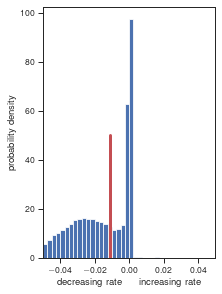

In [22]:

fonts = 1
sns.set(context="paper",style='ticks',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)

plt.figure(8,figsize=(3,4))
bins=np.arange(-0.1,0.05,0.0025)
bi=1000
n='LinB'
chain = results['results'][n]['raw'][1]
leng = chain.shape[2]
chainf = chain[:,bi:,:].reshape(-1,leng)

if n.find('B')>-1:
    scale=10
else:
    scale=100
delta_beta = (10**chainf[:,1] - 10**chainf[:,0])/scale
plt.hist(delta_beta,bins=bins,density=True)
f = plt.gcf()
plt.xlim(-0.05,0.05)
plt.tight_layout()
plt.ylabel('probability density')
plt.plot([np.median(delta_beta),np.median(delta_beta)],[0,50],'r-',lw=3,zorder=5)
plt.xlabel('decreasing rate'+r" ~~~~  "+"increasing rate")
plt.savefig('B.pdf',dpi=600)
#y probability

In [23]:
res = results['results']['x2POP']['raw']
chainf = res[1][:,1000:,:].reshape(-1,3)
import seaborn as sb
import arviz as az

avg=(chainf[:,0]*chainf[:,1])
L=len(avg)
def finds(X):
    return (0.0-len(avg[avg>np.log10(X)])/L)**2

import scipy.optimize
scipy.optimize.minimize(finds,0.01,method='powell')

   direc: array([[6.69737631]])
     fun: array(0.)
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 2
  status: 0
 success: True
       x: array([26.62763939])

In [24]:
res = results['results']['x2POP']['raw']
chainf = res[1][:,1000:,:].reshape(-1,3)
import seaborn as sb
import arviz as az

avg=np.log10(10**chainf[:,0]*chainf[:,1])
L=len(avg)
def finds(X,T):
    return (T-len(avg[avg>np.log10(X)])/L)**2

import scipy.optimize
P=[0.6827,0.7,0.8,0.9,0.9545,0.99]
pd.Series([scipy.optimize.minimize(finds,0.01,args=p,method='powell')['x'][0] for p in P],index=P)

0.6827    0.030990
0.7000    0.029386
0.8000    0.019208
0.9000    0.006112
0.9545    0.000348
0.9900    0.000002
dtype: float64

In [25]:
print(10**az.hdi(avg,hdi_prob=0.6827))
print(10**np.median(avg))


[0.02746828 0.1335416 ]
0.04849662009741154


In [26]:
import seaborn as sb
import arviz as az
avg.min()

-8.27495006346176

<ipython-input-27-d6e13dfa8c64>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])


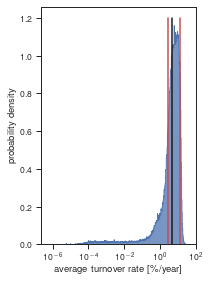

In [27]:
avg=np.log10(10**chainf[:,0]*chainf[:,1])+2

fonts = 1
sns.set(context="paper",style='ticks',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=
       r'''
       \usepackage{siunitx}   
       \sisetup{detect-all}   
       \usepackage{helvet}   
       \usepackage{sansmath}  
       \sansmath'''              # <- tricky! -- gotta actually tell tex to use!
  )


rc('text', usetex=True)

plt.figure(89,figsize=(3,4))
sb.histplot(avg,stat='density',element='step')
f = plt.gcf()
plt.tight_layout()
plt.ylabel('probability density')
l=az.hdi(avg,hdi_prob=0.6827)[0]
plt.plot([l,l],[0,1.2],'r-',lw=1.5,zorder=5)
plt.ylabel('probability density')
plt.xlabel('average turnover rate [\%/year]')
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels([r"$10^{"+str(int(i))+r"}$"  for i in ticks])
plt.tight_layout()
plt.savefig('Blower.pdf',dpi=600)
l=az.hdi(avg,hdi_prob=0.6827)[1]
plt.plot([l,l],[0,1.2],'r-',lw=1.5,zorder=5)
plt.savefig('Bboth.pdf',dpi=600)
l=np.median(avg)
plt.plot([l,l],[0,1.2],'k-',lw=1.5,zorder=5)
plt.savefig('Bmedian.pdf',dpi=600)

In [29]:
10**az.hdi(np.log10(10*10**6/365*(10**chainf[:,0]*chainf[:,1])),hdi_prob=0.683)

array([ 743.84211353, 3620.29459924])

In [31]:
10*10**6/365*10**(np.median(np.log10((10**chainf[:,0]*chainf[:,1]))))

1328.6745232167546

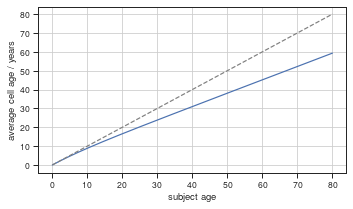

In [28]:
# minimal age
beta=results['point_est'].loc['x2POP',('hdi_15.865%','beta')]
f=results['point_est'].loc['x2POP',('median','f')]


def aage(page,f,rate):
    return page*(1-f)+(1-np.exp(-page*rate))/(rate)*f
plt.rcParams["axes.grid"] = True
a=np.linspace(0,80,1000)
fig=plt.figure(figsize=(5,3))

l,=plt.plot(a,aage(a,f,beta),'-')
l2,=plt.plot(a,aage(a,0,beta),ls='--', color='grey')
plt.xlabel('subject age')
plt.ylabel('average cell age / years')

plt.tight_layout()
# plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))
plt.savefig('E.pdf',dpi=600, bbox_inches='tight')